In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

In [3]:
!wget $data

--2024-10-10 00:39:21--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv’

laptops.csv         100%[===================>] 291.58K  --.-KB/s    in 0.07s   

2024-10-10 00:39:21 (3.91 MB/s) - ‘laptops.csv’ saved [298573/298573]



In [4]:
df = pd.read_csv('laptops.csv')
df.head(2)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

EDA

In [6]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

laptop
['ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core i5-1235U/8GB/512GB SSD/15.6"'
 'Alurin Go Start Intel Celeron N4020/8GB/256GB SSD/15.6"'
 'ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core i3-1215U/8GB/256GB SSD/15.6"'
 'MSI Katana GF66 12UC-082XES Intel Core i7-12700H/16GB/1TB SSD/RTX3050/15.6"'
 'HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB SSD/15.6"']
2160

status
['New' 'Refurbished']
2

brand
['Asus' 'Alurin' 'MSI' 'HP' 'Lenovo']
27

model
['ExpertBook' 'Go' 'Katana' '15S' 'Crosshair']
121

cpu
['Intel Core i5' 'Intel Celeron' 'Intel Core i3' 'Intel Core i7'
 'AMD Ryzen 5']
28

ram
[ 8 16 32 12  4]
9

storage
[ 512  256 1000   64  128]
12

storage_type
['SSD' 'eMMC' nan]
2

gpu
[nan 'RTX 3050' 'RTX 4060' 'RTX 4050' 'RTX 3060']
44

screen
[15.6 17.3 14.  16.1 13.3]
29

touch
['No' 'Yes']
2

final_price
[1009.    299.    789.   1199.    669.01]
1440



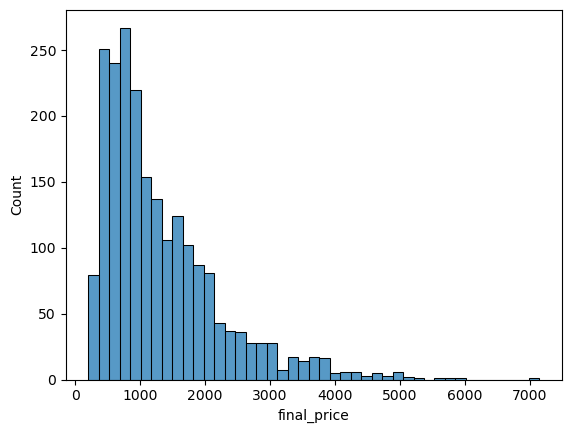

In [7]:
# df['final_price'].describe()

sns.histplot(df.final_price)
plt.show()

1. Column with missing values

In [8]:
df.columns[df.isna().any()].tolist()  # df.columns[df.count() != len(df.index)]

['storage_type', 'gpu', 'screen']

2. The median for variable 'ram'

In [9]:
df['ram'].median()

16.0

3. Better RMSE option

In [10]:
n = len(df.index)
n_test = n_val =  int(0.2*n)
n_train = n - n_val - n_test
# print(n_train, n_val, n_test)
assert n == n_train + n_val + n_test

idx = np.arange(n)

In [11]:
def shuffle_df(seed=42):

    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    # print(len(df_train), len(df_test), len(df_val))
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    # y_train = np.log1p(df_train['final_price'].values)
    # y_val = np.log1p(df_val['final_price'].values)
    # y_test = np.log1p(df_test['final_price'].values)
    
    y_train = df_train['final_price'].values
    y_val = df_val['final_price'].values
    y_test = df_test['final_price'].values
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    
    # print(len(y_train))
    return df_train, df_val, df_test, y_train, y_val, y_test

df_train, df_val, df_test, y_train, y_val, y_test = shuffle_df()

In [12]:
def linear_regression(X, y, r=0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
df_train.dtypes

laptop           object
status           object
brand            object
model            object
cpu              object
ram               int64
storage           int64
storage_type     object
gpu              object
screen          float64
touch            object
dtype: object

In [14]:
# Select numerical features
base = ['ram', 'storage', 'screen']

In [15]:
df_train[base].isna().sum()

ram        0
storage    0
screen     3
dtype: int64

In [16]:
def rmse(y, y_pred):
    e = y - y_pred
    se = np.square(e)
    mse = se.mean()
    rmse = np.sqrt(mse)
    return round(rmse, 2)

Filling NAs:

**Method 1 - By 0**

In [17]:
def prepare_X(df):
    df = df.copy()
    df = df[base]
    df = df.fillna(0)
    return df.values

In [18]:
X_train_0 = prepare_X(df_train)
w0_0, w_0 = linear_regression(X_train_0, y_train)
# y_pred_0 = w0_0 + X_train_0.dot(w_0)

X_val_0 = prepare_X(df_val)
# y_val_pred_0 = np.expm1(w0_0 + X_val_0.dot(w_0))
y_val_pred_0 = w0_0 + X_val_0.dot(w_0)

print('RMSE:',rmse(y_val, y_val_pred_0))

# sns.histplot(y_val_pred_0, color='red', alpha=0.5)
# sns.histplot(y_train, color='blue', alpha=0.5)
# plt.show()

RMSE: 597.36


**Method 2 - By average of individual column**

In [19]:
def prepare_X_avg(df, column, avg=None):
    df = df.copy()
    df = df[base]
    if avg is None:
        avg = df[column].mean()
    
    df.loc[:, column] = df[column].fillna(avg)
    return df.values, avg

In [20]:
X_train_avg, train_screen_avg = prepare_X_avg(df_train, 'screen')
w0_avg, w_avg = linear_regression(X_train_avg, y_train)
# y_pred_avg = w0_avg + X_train_avg.dot(w_avg)

X_val_avg, _ = prepare_X_avg(df_val, 'screen', train_screen_avg)
# y_val_pred_avg = np.expm1(w0_avg + X_val_avg.dot(w_avg))
y_val_pred_avg = w0_avg + X_val_avg.dot(w_avg)

print('RMSE:',rmse(y_val, y_val_pred_avg))

# sns.histplot(y_val_pred_avg, color='red', alpha=0.5)
# sns.histplot(y_train, color='blue', alpha=0.5)
# plt.show()

RMSE: 600.27


4. Which r for the best RMSE

In [21]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = linear_regression(X_train_0, y_train, r)

    # y_pred = np.expm1(w0 + X_val_0.dot(w))
    y_pred = w0 + X_val_0.dot(w)
    print(f'r: {r}\tError: {rmse(y_val, y_pred)}')

r: 0	Error: 597.36
r: 0.01	Error: 597.36
r: 0.1	Error: 597.35
r: 1	Error: 597.21
r: 5	Error: 597.01
r: 10	Error: 597.06
r: 100	Error: 597.9


5. Value of std

In [22]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
result = []

for seed in seeds:
    df_train, df_val, df_test, y_train, y_val, y_test = shuffle_df(seed)

    X_train_0 = prepare_X(df_train)
    w0_0, w_0 = linear_regression(X_train_0, y_train)
    
    X_val_0 = prepare_X(df_val)
    y_val_pred_0 = w0_0 + X_val_0.dot(w_0)
    result.append(rmse(y_val, y_val_pred_0))

print('RMSEs:', result)
print('Standard deviation of the RMSEs:',round(np.std(result), 3))

RMSEs: [650.09, 610.85, 554.12, 584.52, 582.52, 623.52, 608.45, 563.1, 574.91, 591.61]
Standard deviation of the RMSEs: 27.651


6. RMSE on test dataset

In [23]:
df_train, df_val, df_test, y_train, y_val, y_test = shuffle_df(seed=9)
df_train = pd.concat([df_train, df_val], ignore_index=True)
y_train = np.concatenate([y_train, y_val])

X_train_0 = prepare_X(df_train)
w0_0, w_0 = linear_regression(X_train_0, y_train, r=0.001)
    
X_val_0 = prepare_X(df_val)
y_val_pred_0 = w0_0 + X_val_0.dot(w_0)
print('RMSE:',rmse(y_val, y_val_pred_0))

RMSE: 638.3
